In [1]:
import pandas as pd
import math
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# read data
reviews = pd.read_csv("Hotel_Reviews.csv")

# append the positive and negative text reviews
reviews["review"] = reviews["reviews.title"] + "." + reviews["reviews.text"]

reviews["name"] = reviews["name"]

# create the label and make information easy to understanding
reviews["is_good_review"] = reviews["reviews.rating"].apply(lambda x: 1 if x > 3 else 0)

# If it bad is 0
# If it goof is 1

reviews = reviews[["review", "is_good_review", "name"]]
reviews.head()

,review,is_good_review,name
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge


In [2]:
reviews.head(10)

,review,is_good_review,name
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge
5,"Loved staying here.This is such a fun, lovely ...",1,21c Museum Hotel Lexington
6,Does not live up to its reputation.We recently...,0,21c Museum Hotel Lexington
7,worst customer service ever.I reserved a room ...,0,Springs Motel LLC
8,Location Location Location.MoreMore,1,Microtel Inn Suites By Wyndham Lexington
9,"The worst place i've booked.Hello, I have trav...",0,American Inn


In [3]:

# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN
    

In [4]:
def clean_text(text):
    
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    return(text)

# clean text data
#4768 
# for i in range(len(reviews["review"])): reviews["review_clean"] = clean_text(reviews["review"][i])
for i in range(1000): reviews["review_clean"] = clean_text(reviews["review"][i])

In [5]:
#add sentiment anaylsis columns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

In [6]:

# add number of characters column
reviews["nb_chars"] = reviews["review"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["review"].apply(lambda x: len(x.split(" ")))

In [7]:
#create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec.columns = ["doc2vec_vector_" + str(x) for x in doc2vec.columns]
reviews = pd.concat([reviews, doc2vec], axis=1)

unable to import 'smart_open.gcs', disabling that module


In [8]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

In [9]:
reviews["is_good_review"].value_counts(normalize = True)

1    0.7689
0    0.2311
Name: is_good_review, dtype: float64

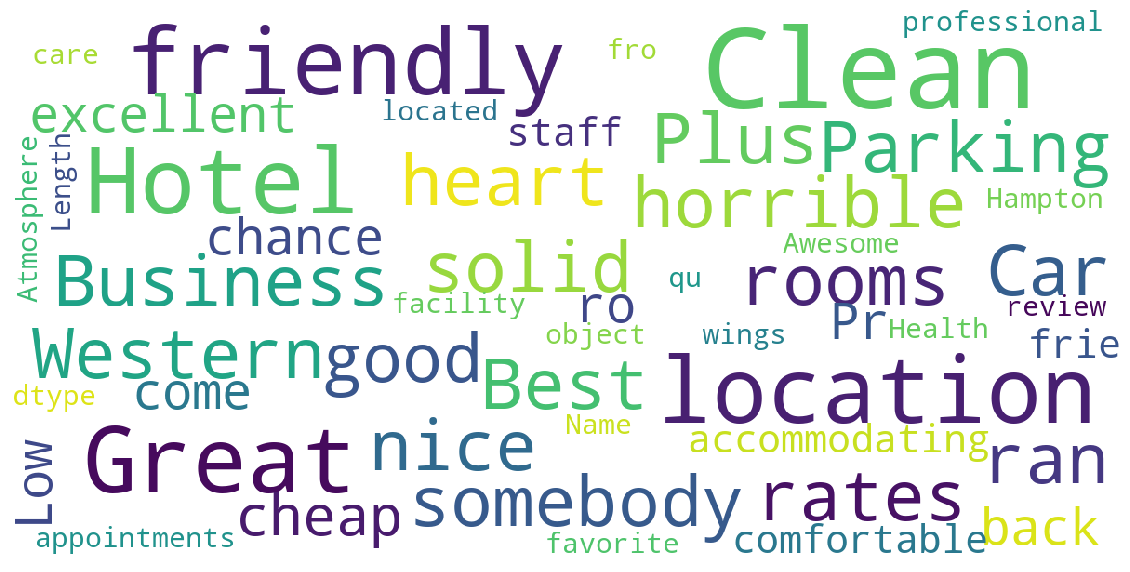

In [10]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews["review"])

In [11]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
9734,Great Hotel.The staff was so nice and helpful....,0.645
1975,"Clean, comfortable, and convenient!.The staff ...",0.641
5185,"Very clean, awesome pool, awesome breakfast.Wo...",0.628
9642,Clean Comfy.Great Hotel. Clean and comfortable...,0.601
7254,Perfect!.This hotel is perfectly located on bu...,0.594
8823,"Awesome NOLA experience.Wonderful staff, frien...",0.586
5199,"Great Experience!.awesome place, we were gladl...",0.583
9562,Great value.walking distance to seaworld or fr...,0.570
7308,Great Best Western.Enjoyed my stay there! Alwa...,0.564
587,"Lovely hotel, great location, nice friendly st...",0.563


In [12]:
# lowest negative sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
3636,This is the WORST hotel and the WORST staff..T...,0.438
6977,Horrible hotel dont waste money.The pictures w...,0.384
2334,"There is no fridge, no microwave, no hanger. T...",0.362
4132,"Horrible, bedbags.Infected of fleas and thumbt...",0.353
4984,good location but room let the whole visit dow...,0.337
282,worst stay...left early.The freezing pool. The...,0.324
9,"The worst place i've booked.Hello, I have trav...",0.317
6591,Do not stay here..Very upset with my stay at t...,0.316
8718,"Gateway to Hell.Employees rude, not helpful. D...",0.313
4481,"Meeting Place.Ice machine broken, telephone br...",0.309


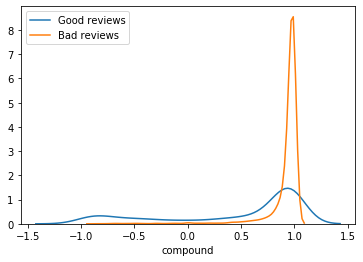

In [13]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews[reviews['is_good_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [14]:
print(reviews)

                                                 review  is_good_review  \
0     Best Western Plus Hotel.This hotel was nice an...               0   
1     Clean rooms at solid rates in the heart of Car...               1   
2     Business.Parking was horrible, somebody ran in...               0   
3     Very good.Not cheap but excellent location. Pr...               1   
4     Low chance to come back here.If you get the ro...               0   
...                                                 ...             ...   
9995  Very accommodating and friendly staff!.My frie...               1   
9996  comfortable, friendly, clean, professional.fro...               1   
9997  Great location.This Hampton is located on a qu...               1   
9998  Great Atmosphere!.Awesome wings (my favorite w...               1   
9999  Health care appointments.Clean facility just o...               1   

                                        name  \
0          Best Western Plus South Coast Inn   
1  

In [15]:
# data set category
cat_good = {
    "staff" : ["friendly", "nice", "good","helpful", "great", "polite", "professional", "excellent", "lovely", "courteous", 
               "courteous", "gentle", "gracious", "modest", "bland", "serviceable", "pleasant", "efficient", "engaging", 
               "wonderful", "attentive"],
    "room" : ["clean", "perfectly", "comfortable", "great", "comfort", "beautiful", "quiet", "well", "perfect", "extraordinary",
            "elegant", "privacy","private","safe", "safety", "big" ,"large", "spacious", "best", "convenient"],
    "location" : ["amazing", "great", "nice", "wonderful", "perfect", "perfectly", "best", "convenient"],
    "price" : ["cheap", "inexpensive", "good", "worth", "worthy"],
    "parking" : ["free", "near", "nice", "big"]
    }

# add colunm about category in 'reviews'
reviews["staff"] = 0
reviews["room"] = 0
reviews["location"] = 0
reviews["price"] = 0
reviews["parking"] = 0

# check category in 'reviews'
for i in range(1000):
    
    lst = reviews["review"][i].lower().split(".")
    
    for text in lst:
        
    # check category about staff in reviews
        if "staff" in text:
            for cate in cat_good["staff"]:
                if cate in text:
                    reviews["staff"][i] += 1
    
    # check category about room in reviews
        if "room" in text:
            for cate in cat_good["room"]:
                if cate in text:
                    reviews["room"][i] += 1
                    
    # check category about location in reviews
        if "location" in text:
            for cate in cat_good["location"]:
                if cate in text:
                    reviews["location"][i] += 1
                    
    # check category about price in reviews
        if "price" in text:
            for cate in cat_good["price"]:
                if cate in text:
                    reviews["price"][i] += 1
    
    # check category about parking in reviews
        if "parking" in text:
            for cate in cat_good["parking"]:
                if cate in text:
                    reviews["parking"][i] += 1

reviews.head(15)

C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A val

,review,is_good_review,name,review_clean,neg,neu,pos,compound,nb_chars,nb_words,...,word_toilet,word_variety,word_very,word_well,word_year,staff,room,location,price,parking
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn,hampton inn.very pet friendly breakfast excell...,0.000,0.777,0.223,0.9042,238,42,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge,hampton inn.very pet friendly breakfast excell...,0.068,0.782,0.150,0.6673,375,70,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,4,0,0,0
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge,hampton inn.very pet friendly breakfast excell...,0.063,0.880,0.057,-0.0772,297,54,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge,hampton inn.very pet friendly breakfast excell...,0.039,0.620,0.340,0.9731,320,53,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,1,0,0,0
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge,hampton inn.very pet friendly breakfast excell...,0.158,0.815,0.028,-0.8141,360,66,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
5,"Loved staying here.This is such a fun, lovely ...",1,21c Museum Hotel Lexington,hampton inn.very pet friendly breakfast excell...,0.049,0.726,0.225,0.8793,360,63,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
6,Does not live up to its reputation.We recently...,0,21c Museum Hotel Lexington,hampton inn.very pet friendly breakfast excell...,0.000,0.897,0.103,0.7184,378,67,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
7,worst customer service ever.I reserved a room ...,0,Springs Motel LLC,hampton inn.very pet friendly breakfast excell...,0.102,0.867,0.031,-0.5018,274,48,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,1,0,0,0
8,Location Location Location.MoreMore,1,Microtel Inn Suites By Wyndham Lexington,hampton inn.very pet friendly breakfast excell...,0.000,1.000,0.000,0.0000,35,3,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0
9,"The worst place i've booked.Hello, I have trav...",0,American Inn,hampton inn.very pet friendly breakfast excell...,0.317,0.683,0.000,-0.9791,329,65,...,0.131306,0.131306,0.131306,0.131306,0.131306,0,0,0,0,0


In [33]:
# new dictionary have hotel's name (key) / category (values)
hotel_reviews = {}
all_hotel = []
count = 0

for i in range(1000):
    
    # add name hotel
    if reviews["name"][i] not in all_hotel:
        hotel_reviews[count] = {"name" : reviews["name"][i], "staff" : 0, "room" : 0, "location" : 0, "price" : 0, "parking" : 0, "score" : 0}
        all_hotel.append(reviews["name"][i])
        count += 1
        
    # add values category hotel
    else:
        ind = all_hotel.index(reviews["name"][i]) # find index for find hotel

        hotel_reviews[ind]["staff"] += reviews["staff"][i]
        hotel_reviews[ind]["room"] += reviews["room"][i]
        hotel_reviews[ind]["location"] += reviews["location"][i]
        hotel_reviews[ind]["price"] += reviews["price"][i]
        hotel_reviews[ind]["parking"] += reviews["parking"][i]
        hotel_reviews[ind]["score"] += reviews["staff"][i] + reviews["parking"][i]\
                                                    + reviews["room"][i] + reviews["location"][i] + reviews["price"][i]
        
# sorted hotel reviews by score (high to low)
hotel_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['score'], reverse=True))
print(hotel_reviews)

{48: {'name': 'Grand Hyatt Seattle', 'staff': 79, 'room': 204, 'location': 81, 'price': 4, 'parking': 1, 'score': 369}, 69: {'name': 'Drury Inn & Suites New Orleans', 'staff': 131, 'room': 178, 'location': 40, 'price': 5, 'parking': 7, 'score': 361}, 23: {'name': 'Best Western Seven Seas', 'staff': 103, 'room': 162, 'location': 60, 'price': 7, 'parking': 20, 'score': 352}, 29: {'name': 'Hotel Abri', 'staff': 89, 'room': 108, 'location': 63, 'price': 7, 'parking': 0, 'score': 267}, 82: {'name': 'Hampton Inn San Diego Del Mar', 'staff': 50, 'room': 55, 'location': 20, 'price': 2, 'parking': 15, 'score': 142}, 24: {'name': 'Quality Suites San Diego SeaWorld Area', 'staff': 34, 'room': 65, 'location': 14, 'price': 3, 'parking': 5, 'score': 121}, 9: {'name': 'The Whitney Hotel', 'staff': 44, 'room': 47, 'location': 20, 'price': 2, 'parking': 0, 'score': 113}, 20: {'name': 'Hampton Inn San Diego/Mission Valley', 'staff': 41, 'room': 38, 'location': 15, 'price': 0, 'parking': 2, 'score': 96},

In [34]:
# Dictionary to Dataframe
hotel_reviews = pd.DataFrame.from_dict(hotel_reviews, orient='index')

#        staff room location price parking score
# name0    1    2      3       4     5       6
# name1    1    2      3       4     5       6
# name2    1    2      3       4     5       6
# name3    1    2      3       4     5       6

hotel_reviews.head(83)

,name,staff,room,location,price,parking,score
48,Grand Hyatt Seattle,79,204,81,4,1,369
69,Drury Inn & Suites New Orleans,131,178,40,5,7,361
23,Best Western Seven Seas,103,162,60,7,20,352
29,Hotel Abri,89,108,63,7,0,267
82,Hampton Inn San Diego Del Mar,50,55,20,2,15,142
...,...,...,...,...,...,...,...
74,Comfort Inn Buckhead North,0,0,0,0,0,0
75,Hyatt Place Atlanta Buckhead,0,0,0,0,0,0
78,Partridge Inn,0,0,0,0,0,0
79,Park Hyatt Beaver Creek Resort and Spa,0,0,0,0,0,0


In [85]:
# Top 10 Ranking Score to create bar graph

# List for name of Hotels
lst = [i for i in hotel_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])

# List for score of Staff
lst = [i for i in hotel_reviews['staff']]
staff = []
for i in range(10):
    staff.append(lst[i])

# List for score of Room
lst = [i for i in hotel_reviews['room']]
room = []
for i in range(10):
    room.append(lst[i])
    
# List for score of Location
lst = [i for i in hotel_reviews['location']]
location = []
for i in range(10):
    location.append(lst[i])
    
# List for score of Price
lst = [i for i in hotel_reviews['price']]
price = []
for i in range(10):
    price.append(lst[i])
    
# List for score of Parking
lst = [i for i in hotel_reviews['parking']]
parking = []
for i in range(10):
    parking.append(lst[i])


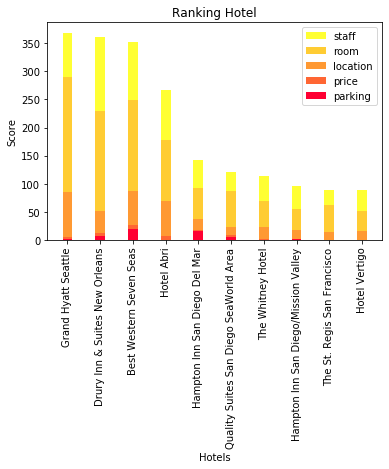

<Figure size 1440x720 with 0 Axes>

In [86]:
# Create Stacked Bar Graph =w=
staff = np.array(staff)
room = np.array(room)
location = np.array(location)
price = np.array(price)
parking = np.array(parking)
ind = [name for name in names]

# Stacked Graph
plt.bar(ind, staff, width=0.3, label='staff', color='#FFFF33', bottom=room+location+price+parking) # Staff
plt.bar(ind, room, width=0.3, label='room', color='#FFCC33', bottom=location+price+parking)        # Room
plt.bar(ind, location, width=0.3, label='location', color='#FF9933', bottom=price+parking)         # Location
plt.bar(ind, price, width=0.3, label='price', color='#FF6633', bottom=parking)                     # Price
plt.bar(ind, parking, width=0.3, label='parking', color='#FF0033')                                 # Parking

# Plot Graph
plt.xticks(ind, names, rotation=90)
plt.ylabel("Score")
plt.xlabel("Hotels")
plt.legend(loc="upper right")
plt.title("Ranking Hotel")

# Fig size ยังไงไม่รู้
plt.figure(figsize=(20, 10))

# Show Graph
plt.show()

In [43]:
print([name for name in hotel_reviews['name']])

['Grand Hyatt Seattle', 'Drury Inn & Suites New Orleans', 'Best Western Seven Seas', 'Hotel Abri', 'Hampton Inn San Diego Del Mar', 'Quality Suites San Diego SeaWorld Area', 'The Whitney Hotel', 'Hampton Inn San Diego/Mission Valley', 'The St. Regis San Francisco', 'Hotel Vertigo', 'W Seattle', 'Drury Inn Suites Colorado Springs Near The Air Force Academy', 'Four Points by Sheraton San Diego - SeaWorld', 'Marriott Vacation Club Pulse, San Diego', 'Courtyard by Marriott San Diego Old Town', 'The Ocean Lodge', 'Quality Inn', 'The Westin Atlanta Airport', 'Hampton Inn Atlanta Buckhead', 'Days Inn Nashville North Opryland / Grand Ole Opry Area', 'Wyndham Philadelphia-Historic District', 'Best Western Clermont', 'Omni San Diego Hotel', 'Saddle Surrey Motel', 'Residence Inn Provo', 'Hilton Garden Inn Columbus Dublin', "Best Western Carmel's Town House Lodge", 'West Bank Inn', 'Bluewater Resort Casino', 'Econo Lodge', 'Comfort Inn & Suites Seattle', 'Best Western Twin Islands', 'Hampton Inn S